In [231]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
task = 2

results_folder = "/cephyr/users/frejohk/Alvis/projects/mnist_transfer/results/task2/Binary"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
r_files = [f for f in os.listdir(results_folder) if 'results.pkl' in f]

D = pd.DataFrame({})

for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0)
    
D['germain_bound'] = np.nan
D['beta_bound'] = np.nan

D = D.sort_values(by=['Weightupdates', 'alpha', 'sigma'])


In [283]:
m_bound = D['m_bound'].values[0]
delta = D['delta'].values[0]

 # calculate disrho bound
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        stratum = (D['sigma']==s)&(D['alpha']==a)
        train_germain = D[stratum]['train_germain'].values
        e_s = D[stratum]['e_s'].values
        e_t = D[stratum]['e_t'].values
        d_tx = D[stratum]['d_tx'].values
        d_sx = D[stratum]['d_sx'].values
        KL = D[stratum]['KL'].values

        res, bestparam, boundparts = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL))
        res_inf, _, _ = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL))

        # calculate beta bound
        [res2, bestparam2, boundparts2] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL),beta_bound=True)
        [res2_inf, _, _] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL),beta_bound=True)

        D.loc[stratum,'germain_bound'] = res
        D.loc[stratum,'beta_bound'] = res2
        D.loc[stratum,'germain_bound_inf'] = res_inf
        D.loc[stratum,'beta_bound_inf'] = res2_inf



Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....
Starting gridsearch....


,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,0,0.458452,0.615084,108890.373182,0.403669,0.559097,0.111972,0.109564,0.008103,0.015964,...,1_0,0.05,70010,69990,10,69105,7.883036,60.238409,0.538976,4.491867
0,0,0.454072,0.568170,32815.586600,0.316461,0.425965,0.284409,0.275222,0.026694,0.034848,...,1_0,0.05,70010,69990,10,69105,3.907022,27.897081,0.518402,3.619780
0,0,0.475761,0.528551,10720.384765,0.254317,0.302322,0.452459,0.442888,0.028772,0.043306,...,1_0,0.05,70010,69990,10,69105,2.136754,14.504424,0.509715,3.020934
0,0,0.077747,0.175401,0.000000,0.073555,0.169170,0.012463,0.008385,0.002653,0.003945,...,1_0,0.05,63009,69990,10,69105,0.164115,0.872841,0.129927,0.814514
0,0,0.081476,0.181668,0.000000,0.067438,0.158464,0.046408,0.028077,0.007934,0.015198,...,1_0,0.05,63009,69990,10,69105,0.172195,0.914061,0.145614,0.764276


Sigma = 0.00300 Alpha = 0.00000


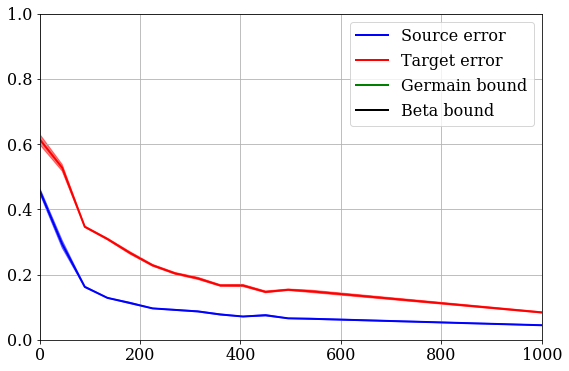

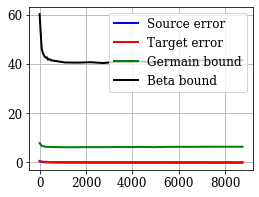

Sigma = 0.01000 Alpha = 0.00000


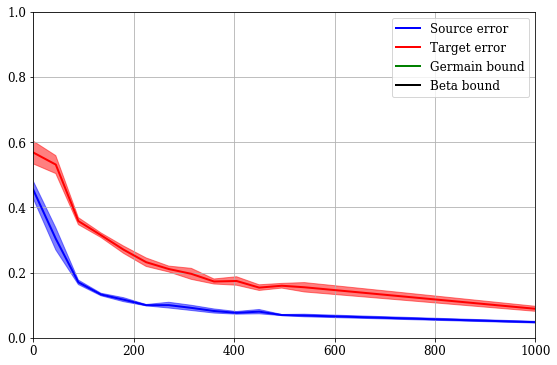

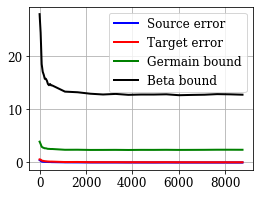

Sigma = 0.03000 Alpha = 0.00000


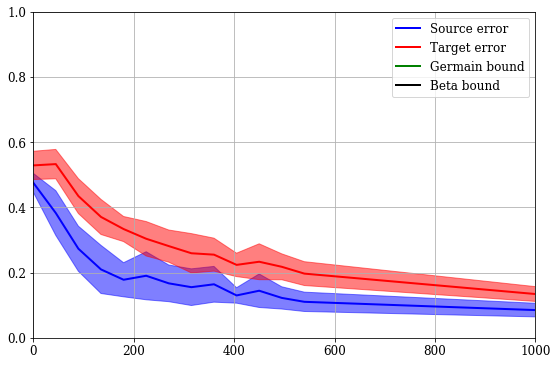

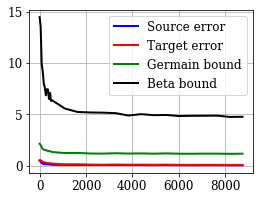

Sigma = 0.00300 Alpha = 0.10000


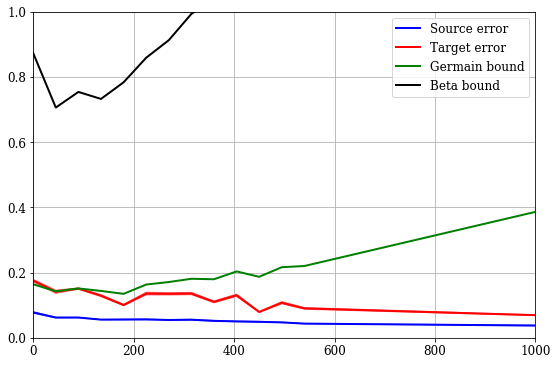

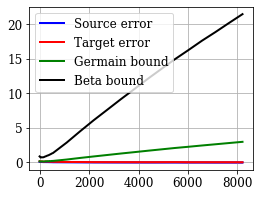

Sigma = 0.01000 Alpha = 0.10000


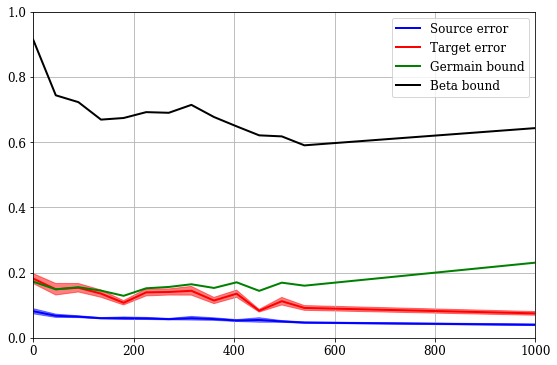

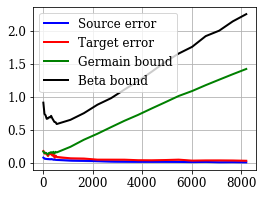

Sigma = 0.03000 Alpha = 0.10000


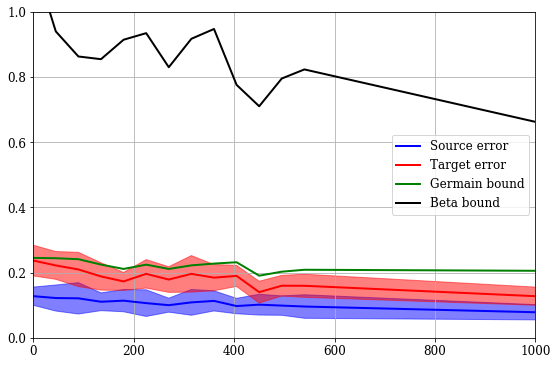

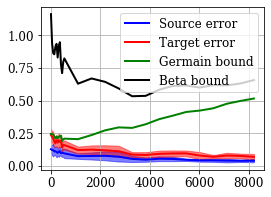

In [287]:
plt.rc('font', size=16, family='serif')
display(D.head(5))

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

        stratum = (D['sigma']==s)&(D['alpha']==a)
        ws = D[stratum]['Weightupdates']
        e_so = D[stratum]['train_germain']
        e_ta = D[stratum]['target_germain']
        e_so_std = D[stratum]['error_std']
        e_ta_std = D[stratum]['target_error_std']
        KL = D[stratum]['KL']
        gb = D[stratum]['germain_bound']
        bb = D[stratum]['beta_bound']       

        plt.figure(figsize=(9,6))
        plt.grid(zorder=-100)

        plt.plot(ws, e_so, label='Source error', lw=2, c='b')
        plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')

        plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
        plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')

        plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
        plt.plot(ws, bb, label='Beta bound', lw=2, c='k')

        plt.xlim(0, 1000)
        plt.ylim(0, 1.)
        plt.legend()


        plt.rc('font', size=12, family='serif')
        plt.figure(figsize=(4,3))
        plt.grid(zorder=-100)

        plt.plot(ws, e_so, label='Source error', lw=2, c='b')
        plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')

        plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
        plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')

        plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
        plt.plot(ws, bb, label='Beta bound', lw=2, c='k')

        plt.legend()
        plt.show()

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,0,0.458452,0.615084,108890.373182,0.403669,0.559097,0.111972,0.109564,0.008103,0.015964,...,1_0,0.05,70010,69990,10,69105,7.883036,60.238409,0.538976,4.491867
0,0,0.454072,0.568170,32815.586600,0.316461,0.425965,0.284409,0.275222,0.026694,0.034848,...,1_0,0.05,70010,69990,10,69105,3.907022,27.897081,0.518402,3.619780
0,0,0.475761,0.528551,10720.384765,0.254317,0.302322,0.452459,0.442888,0.028772,0.043306,...,1_0,0.05,70010,69990,10,69105,2.136754,14.504424,0.509715,3.020934
0,0,0.077747,0.175401,0.000000,0.073555,0.169170,0.012463,0.008385,0.002653,0.003945,...,1_0,0.05,63009,69990,10,69105,0.164115,0.872841,0.129927,0.814514
0,0,0.081476,0.181668,0.000000,0.067438,0.158464,0.046408,0.028077,0.007934,0.015198,...,1_0,0.05,63009,69990,10,69105,0.172195,0.914061,0.145614,0.764276


Sigma = 0.00300 Alpha = 0.00000


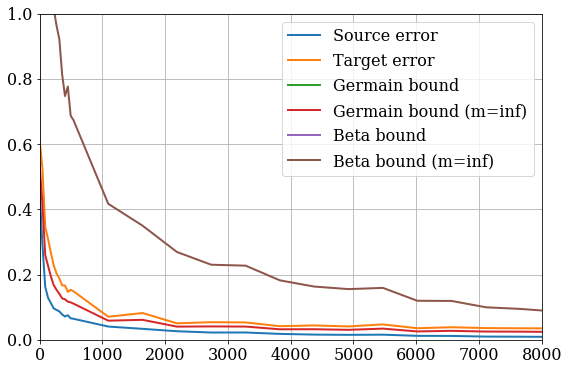

Sigma = 0.01000 Alpha = 0.00000


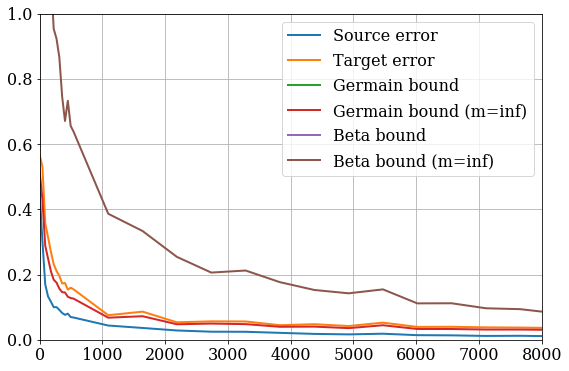

Sigma = 0.03000 Alpha = 0.00000


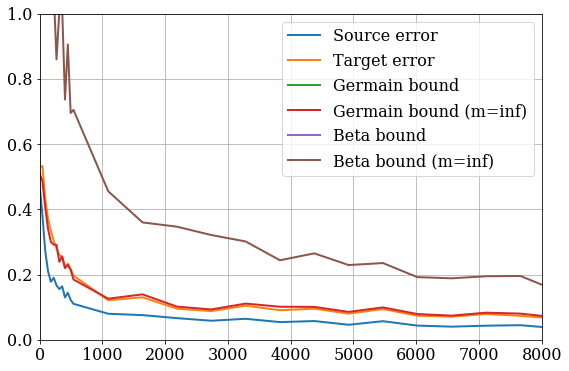

Sigma = 0.00300 Alpha = 0.10000


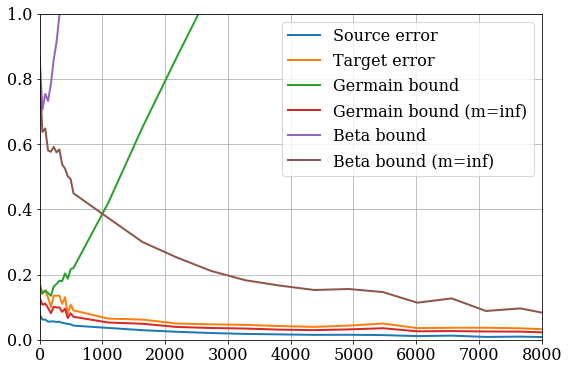

Sigma = 0.01000 Alpha = 0.10000


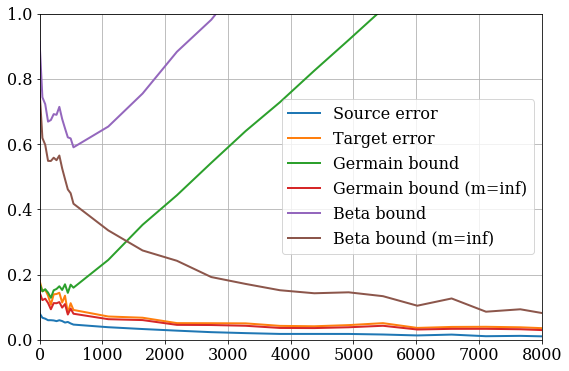

Sigma = 0.03000 Alpha = 0.10000


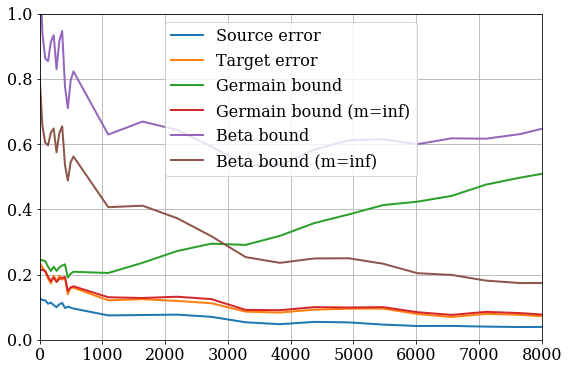

In [290]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

        stratum = (D['sigma']==s)&(D['alpha']==a)
        ws = D[stratum]['Weightupdates']
        e_so = D[stratum]['train_germain']
        e_ta = D[stratum]['target_germain']
        e_so_std = D[stratum]['error_std']
        e_ta_std = D[stratum]['target_error_std']
        KL = D[stratum]['KL']
        gb = D[stratum]['germain_bound']
        gbi = D[stratum]['germain_bound_inf']
        bb = D[stratum]['beta_bound']       
        bbi = D[stratum]['beta_bound_inf']       

        plt.figure(figsize=(9,6))
        plt.grid(zorder=-100)

        plt.plot(ws, e_so, label='Source error', lw=2)    
        plt.plot(ws, e_ta, label='Target error', lw=2)    
        plt.plot(ws, gb, label='Germain bound', lw=2)
        plt.plot(ws, gbi, label='Germain bound (m=inf)', lw=2)
        plt.plot(ws, bb, label='Beta bound', lw=2)
        plt.plot(ws, bbi, label='Beta bound (m=inf)', lw=2)
        plt.xlim(0, 8000)
        plt.ylim(0, 1)

        plt.legend()
        plt.show()